# Tweets extractor

Ferramenta para extrair tweets de um dado utilizador (usando o nome de utilizador) utilizando a API oficial do twitter.


É necessario:
1) Chaves de autenticaçao para API.
2) Utilizar biblioteca tweepy.
3) Fazer os pedidos necessario a API.


Para utilizar o Tweepy existem 4 passos a executar:  
1) Importar o package;
2) Definir as credenciais de autenticaçao;
3) Instanciar a API;
4) Crear o objeto API; 


In [1]:
import os
import openai
import requests
import re  ## To use regular expressions
import tweepy
import json
import pandas as pd
from dotenv import load_dotenv
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
import nltk 
import collections
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS

load_dotenv()

/opt/homebrew/anaconda3/envs/py3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


True

In [2]:
# authenticating twitter api credentials
consumer_key = os.getenv('consumer_key')
consumer_secret = os.getenv('consumer_secret')
access_token = os.getenv('access_token')
access_token_secret = os.getenv('access_token_secret')
OPENAI_api_key = os.getenv("openAI")
Humantic_AI = os.getenv("humanticAI")



In [3]:
def sentimentAnalysis_openAI (text):
    
    openai.api_key = OPENAI_api_key

    response = openai.Completion.create(
    engine="text-curie-001",
    prompt=text,
    temperature=0,
    max_tokens=60,
    top_p=1,
    frequency_penalty=0.5,
    presence_penalty=0
    )
    output = response.choices[0].text

    return output

In [4]:

# instantiating the api
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# creating API object
api = tweepy.API(auth)

In [6]:
user = api.get_user(screen_name='apfactcheck')
'''
status_count - The number of Tweets (including retweets) issued by the user
favourites_count - number of posts liked by the user
'''
#user

'\nstatus_count - The number of Tweets (including retweets) issued by the user\nfavourites_count - number of posts liked by the user\n'

In [56]:

def extract_last_n_tweets(username, n = 400):
    '''
    n, numero de tweets a extrair
    n = 400 tem expressão estatistica
    user, utilizador que se pretende procurar
    '''
    like = 0
    retweet = 0
    user = api.get_user(screen_name=username)
    followers_count =user.followers_count
    try:
        userTweets = tweepy.Cursor(api.user_timeline, screen_name=username, tweet_mode='extended').items(n)
       
        for tweet in userTweets:
            text = tweet._json["full_text"]
           

            '''
            Garantir que apenas ficam os posts originais, de movo a evitar desvios
            '''
            
            if 'RT ' not in text:
                t =  text,
                likes_count  = tweet.favorite_count
                retweet_count =  tweet.retweet_count
                like = like + likes_count
                retweet = retweet + retweet_count

            
        m = 'True'
        return True, like, retweet, followers_count
    except:
        m = "extract_last_n_tweets] erro duranre a extraçao de tweets de um utilizador " + username
    return False, m



In [63]:
value,  like, retweet, followers_count = extract_last_n_tweets('apfactcheck')

In [64]:
print(like/400, retweet/400, followers_count)
print((like/400 + retweet/400)/followers_count * 100 )

309.195 169.2 77956
0.6136730976448252


In [61]:
value,  like, retweet, followers_count = extract_last_n_tweets('snopes')
print(like/400, retweet/400, followers_count)

print((16 + 5)/303750 * 100 )

15.64 4.7375 303750
0.00691358024691358


In [8]:
def extract_user_info(username):
    try:
            user = api.get_user(screen_name=username)
            
            '''
            status_count - The number of Tweets (including retweets) issued by the user
            favourites_count - number of posts liked by the user
            '''
            """ Extrair numeros da descriçao.
            É muito frequente na descriçao os utilziadores colocarem a seua idade"""
            nums = re.findall(r'\d+', user.description.replace('\n', ' ')) 
            n = 0
            for num in nums:
                if int(num )> 16 and int(num )< 80:
                    n = int(num)

            followers_count =user.followers_count
            friends_count = user.friends_count
            statuses_count =  user.statuses_count
            favourites_count =  user.favourites_count
            description =  user.description.replace('\n', ' ')
            protected = user.protected
            age = n
            
            if protected == True:
                return False, 'Esta conta é protegida'


            '''
            Crir o objeto obj para retornar
            '''
            obj = {
            'username': username,
            'followers_count': followers_count,
            'statuses_count': statuses_count,
            'friends_count' : friends_count,
            'favourites_count' : favourites_count, 
            'description': description,
            'age':age,
            }

           

            return True, obj

    except:
        m = "[extract_user_info] erro duranre a extraçao da info de um utilizador " + username
 
    return False, m

In [20]:
extract_user_info('apfactcheck')

(True,
 {'username': 'apfactcheck',
  'followers_count': 77955,
  'statuses_count': 1518,
  'friends_count': 12,
  'favourites_count': 0,
  'description': 'Fact-checking, accountability journalism and misinformation coverage from @AP journalists around the globe. Getting the facts right since 1846. FactCheck@ap.org',
  'age': 0})

In [9]:
def avg (list):
    return (sum(list)//len(list))

In [10]:
'''
Funçao responsavel por fazer o calculo a media de tempo entre cada post.
O tempo retornado é em minutos;
'''

def range_date (date):
  list_minutes = []
  initial = date[0]
  for next_date in date[1:]:
    range = initial - next_date 
    minutes = range.total_seconds() // 60
    list_minutes.append(minutes)
    initial = next_date
  return avg(list_minutes)



In [11]:
'''
Funçao reponsavel por realizar analise de sentimentos aos tweets;

@author emotionsmater.com
'''
import requests

def sentimentAnalysis(list_tweets,lang):
    body = {

        "messages": list_tweets,
        "language": lang

        }

    request = requests.post("http://146.59.159.119:9777", json = body)
    return (request.text.encode().decode('unicode-escape') , request.status_code)


In [ ]:
sentimentAnalysis(['Quem sofrer de violencia doméstica por favor DENUNCIE! Ninguém merece passar por isto 🤬 Cadeia com todos estes FDP!'],'pt')

In [13]:
from textblob import TextBlob 


def get_tweet_sentiment(listTweets): 
    ''' 
    Determina o sentimento dos tweets
    '''
    
    neg = 0
    pos = 0
    neutral = 0

    for tweet in listTweets:
        # create TextBlob object of passed tweet text
        analysis = TextBlob(tweet) 
        # set sentiment 
        if analysis.sentiment.polarity > 0: 
            pos += 1
        elif analysis.sentiment.polarity == 0: 
            neutral += 1
        else: 
            neg += 1

    total_tweets = neg + pos + neutral
    print("\n\nRESULTS:")
    print(f"{total_tweets} tweets were analyzed. {neg} were negative, {pos} were positive and {neutral} were neutral")
    print(f"The negative percentage is: % { round( ((neg/total_tweets) * 100), 2) if neg > 0 else 0}")
    print(f"The positive percentage is: % { round( ((pos/total_tweets) * 100), 2) if pos > 0 else 0}")
    print(f"The neutral percentage is: % { round( ((neutral/total_tweets) * 100), 2) if neutral > 0 else 0}")

    return (total_tweets, neg, pos, neutral)


In [14]:
def compile_stopwords_list_frequency(text, freq_percentage=0.02):
    words = nltk.tokenize.word_tokenize(text)
    freq_dist = FreqDist(word.lower() for word in words)
    words_with_frequencies = [(word, freq_dist[word]) for word in freq_dist.keys()]
    sorted_words = sorted(words_with_frequencies, key=lambda tup: tup[1])
    length_cutoff = int(freq_percentage*len(sorted_words))
    stopwords = [tuple[0] for tuple in sorted_words[-length_cutoff:]] 
    return stopwords

In [15]:
def stopWords():
    stopWords = ['https',"0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"]
    return stopWords

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
def top_n_words(language, corpus,n = None,ngram = 1):

    # Contar o número de todas as palavras  nas reviews
    vec = CountVectorizer(stop_words = language,ngram_range=(ngram,ngram)).fit(corpus)
    
    bag_of_words = vec.transform(corpus) 

    sum_words = bag_of_words.sum(axis =0) 
    words_freq = [(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    
    words_freq = sorted(words_freq,key = lambda x:x[1],reverse = True)
    
    return words_freq[:n]




In [17]:
if not os.path.exists('TweetsByUser'):
    os.makedirs('TweetsByUser')


def main (users):
    for username in users:
        
        '''
        1) Extrair informaçao do utilizador
        '''
        value, userdata = extract_user_info (username)
        
        if value == False:
            print(userdata)
            continue

                
        '''
        Extrair os ultimos 25% (1/4) dos ultimos tweets publicados 
        '''
       # print(userdata['statuses_count']*5 // 100)
        value, userTweets = extract_last_n_tweets (username, userdata['statuses_count']*5 // 100)
        print(value)

        if value == False:
            continue

        list_tweets = []
        list_tweet_text = []
        list_dates = []


        for tweet in userTweets:

            text = tweet._json["full_text"]
           

            '''
            Garantir que apenas ficam os posts originais, de movo a evitar desvios
            '''
            
            if 'RT ' not in text:
                refined_tweet = {'text' : text,
                    'likes_count' : tweet.favorite_count,
                    'retweet_count' : tweet.retweet_count,
                    'created_at' : tweet.created_at.strftime("%m/%d/%Y, %H:%M:%S")}
                list_dates.append (tweet.created_at)
                list_tweet_text.append(text)
                list_tweets.append(refined_tweet)

            #df = pd.DataFrame(list_tweet_text,columns=['Text']) 
            #creates a pandas dataframe
           # df.to_csv(username + '.csv', sep=',', index = False) 
            #creates a csv from data frame

        all_headlines = ' '.join(list_tweet_text).lower()
        wordcloud = WordCloud(stopwords=stopWords(), background_color="white", max_words=1000).generate(all_headlines)
        
        stopwords=stopWords()

        tweets = [tweet for tweet in all_headlines.split() if tweet not in stopwords if 'https' or '@' not in tweet ]
        
        print(top_n_words('english', tweets, 10, 1))
                    
        rcParams['figure.figsize'] = 10, 20
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
        '''
        Calcular diferença entre os intervalos em minutos;
        '''
        
        #avg=pd.to_datetime(pd.Series(list_dates)).mean()
        
        avg= range_date(list_dates)
        userdata['periodicity'] = avg
        

        '''
        Invocar a funçao de analise de sentimentos, sobre a lista de tweets do user
        O objetivo é perceber o conjunto de emoçoes presents
        '''
      #  print(list_tweet_text)
        total_tweets, neg, pos, neutral = get_tweet_sentiment (list_tweet_text)

      
        userdata['neg_count'] = neg
        userdata['pos_count'] = pos
        userdata['neutral_count'] = neutral
        userdata['tweets_count'] = total_tweets
        userdata['tweets'] = list_tweets
        
        #print(userdata)
        
        with open("TweetsByUser/" + username +  ".json", "w", encoding = 'utf8') as jsonFile:
            json.dump(userdata, jsonFile, indent = 4, ensure_ascii=False)

        
       # df.to_csv('TweetsByUser/'+ username +'.csv')

        


True
[('https', 141), ('keaneli', 86), ('msswiggy', 37), ('deadprogrammer', 21), ('jperras', 17), ('coates', 16), ('whatjoewrote', 15), ('dzuelke', 14), ('cerpintor', 13), ('read', 11)]


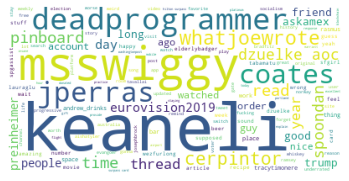



RESULTS:
488 tweets were analyzed. 80 were negative, 138 were positive and 270 were neutral
The negative percentage is: % 16.39
The positive percentage is: % 28.28
The neutral percentage is: % 55.33
True
[('https', 9), ('time', 3), ('sohini_basak', 2), ('tamlynrogers', 2), ('moved', 2), ('loops', 2), ('step', 2), ('real', 2), ('magic', 2), ('interesting', 2)]


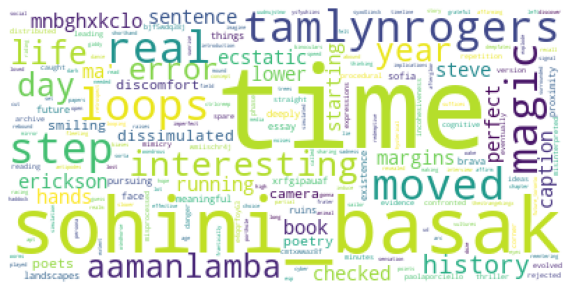



RESULTS:
24 tweets were analyzed. 5 were negative, 10 were positive and 9 were neutral
The negative percentage is: % 20.83
The positive percentage is: % 41.67
The neutral percentage is: % 37.5
True
[('https', 117), ('people', 85), ('great', 66), ('work', 42), ('time', 36), ('good', 36), ('years', 29), ('thing', 26), ('things', 25), ('love', 22)]


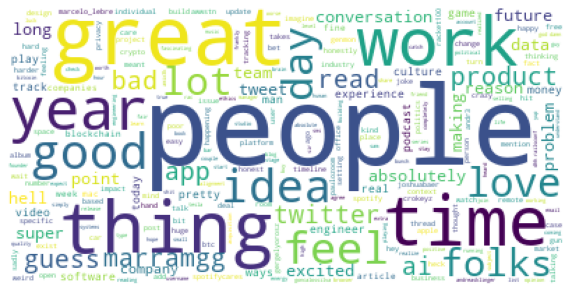



RESULTS:
656 tweets were analyzed. 121 were negative, 387 were positive and 148 were neutral
The negative percentage is: % 18.45
The positive percentage is: % 58.99
The neutral percentage is: % 22.56
True
[('https', 141), ('keaneli', 86), ('msswiggy', 37), ('deadprogrammer', 21), ('jperras', 17), ('coates', 16), ('whatjoewrote', 15), ('dzuelke', 14), ('cerpintor', 13), ('read', 11)]


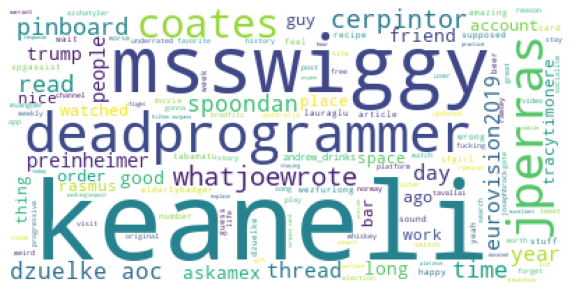



RESULTS:
488 tweets were analyzed. 80 were negative, 138 were positive and 270 were neutral
The negative percentage is: % 16.39
The positive percentage is: % 28.28
The neutral percentage is: % 55.33
[extract_user_info] erro duranre a extraçao da info de um utilizador c
True
[('https', 957), ('amp', 194), ('indieweb', 110), ('indiewebcamp', 73), ('day', 62), ('today', 42), ('30', 41), ('morning', 40), ('yesterday', 40), ('website', 39)]


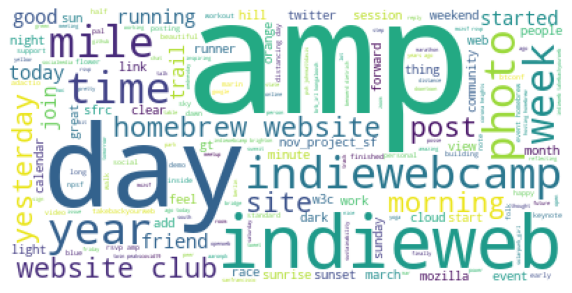



RESULTS:
502 tweets were analyzed. 90 were negative, 319 were positive and 93 were neutral
The negative percentage is: % 17.93
The positive percentage is: % 63.55
The neutral percentage is: % 18.53
[extract_user_info] erro duranre a extraçao da info de um utilizador c
True
[('https', 61), ('em_meehan', 44), ('cc', 40), ('iamkevinholler', 37), ('cloudsteph', 35), ('time', 25), ('good', 20), ('http', 19), ('coates', 19), ('tho', 14)]


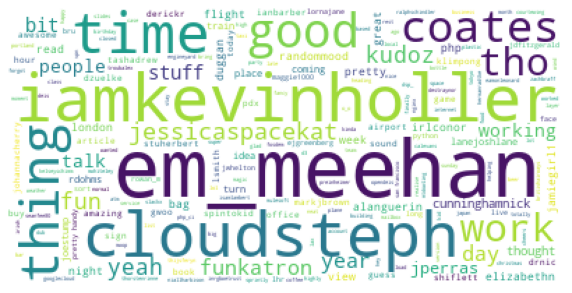



RESULTS:
498 tweets were analyzed. 75 were negative, 250 were positive and 173 were neutral
The negative percentage is: % 15.06
The positive percentage is: % 50.2
The neutral percentage is: % 34.74
[extract_user_info] erro duranre a extraçao da info de um utilizador e
[extract_user_info] erro duranre a extraçao da info de um utilizador c
True


KeyboardInterrupt: 

In [18]:
#users = ['filipaa_r99']
main('apfactcheck')

In [59]:
list_username = [
    "MichelleObama", 'KendallJenner', 'KimKardashian', 'BarackObama', 'elonmusk'
]

In [17]:
def fetch_user(username):
    BASE_URL = "https://api.humantic.ai/v1/user-profile"  # Base URL for the FETCH endpoint
    headers = {
        'Content-Type': 'application/json'
    }

    # Analysis ID: required; should be same as the id used to create the analysis
    USER_ID = "https://twitter.com/" + username  # or, any unique identifier

    # Persona: optional; possible values: "sales", "hiring"
    PERSONA = "sales"

    url = f"{BASE_URL}?apikey={Humantic_AI}&id={USER_ID}&persona={PERSONA}"

    response = requests.request("GET", url, headers=headers)

    response_json =  json.loads(response.text)

    print(response_json['results'])

    '''
    Retornar os dados da personalidade
    '''
    return (response_json['results']['personality_analysis']['summary']['ocean']['label'],response_json['results']['personality_analysis']['ocean_assessment'])


In [18]:

def creat_user(username):
    BASE_URL = "https://api.humantic.ai/v1/user-profile/create"  # Base URL for the CREATE endpoint
    headers = {
        'Content-Type': 'application/json'
    }


    # Analysis ID: required; User profile link from LinkedIn or, User Email ID
    # or, for document or text, use any unique identifier. We suggest using a value that helps you identify the analysis easily.
    USER_ID = "https://twitter.com/" + username 

    url = f"{BASE_URL}?apikey={Humantic_AI}&id={USER_ID}"

    payload = {}

    response = requests.request("GET", url, headers=headers, data=payload)
    if (response.status_code == 200):
        return fetch_user (username)

    return False

In [22]:
outuput = creat_user('dduraes')
outuput

{'first_name': 'Dalila', 'last_name': 'Durães', 'display_name': 'DALILA DURÃES', 'user_profile_image': 'http://pbs.twimg.com/profile_images/1311269860467499009/Azn5afHd_normal.jpg', 'user_name': 'https://twitter.com/dduraes', 'user_id': '8c60053a942e46f837fb', 'user_description': 'Passionate about the Past seen from the Future.\n@Portugal @Guimaraes @Braga', 'demographics': {'junk_user': None, 'gender': 'female', 'employment_status': [], 'marital_status': [], 'profession': [], 'user_type': 'person', 'location': {'country': 'portugal', 'type': 'country'}, 'parental_status': []}, 'languages': [{'code': 'eu', 'percent': 2, 'language': 'Basque'}, {'code': 'pt', 'percent': 16, 'language': 'Portuguese'}, {'code': 'qme', 'percent': 6, 'language': 'Undetermined'}, {'code': 'en', 'percent': 65, 'language': 'English'}, {'code': 'zxx', 'percent': 4, 'language': 'Undetermined'}, {'code': 'fr', 'percent': 2, 'language': 'French'}], 'social_profiles': {}, 'photos': {}, 'websites': {}, 'location': {}

(['n', 'o', 'c'],
 {'openness': {'score': 6.92, 'level': 'Open'},
  'extraversion': {'score': 5.71, 'level': 'Somewhat Introverted'},
  'emotional_stability': {'score': 7.08, 'level': 'Balanced'},
  'agreeableness': {'score': 5.1, 'level': 'Disagreeable'},
  'conscientiousness': {'score': 6.04, 'level': 'Somewhat Conscientious'}})